# 分類器を作成する
以下のチュートリアルを用いて、分類器の作成の手順をまとめておく。

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=data%20loader

`torchvision.datasets`を用いることで、有名どころのデータセットを簡単に使うことができる。またこの中には、ローカルのディレクトリから簡単にデータセットを作ることができるクラスなども用意されているようだ。

`torchvision.datasets` と　`torch.utils.data.DataLoade` を使うと画像のデータセットを作るのに便利である。

ここではCIFAR10を用いる。各画像の大きさは3x32x32である。

>For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## CIFAR10のロード

In [169]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision.transformsはPIL（Pillow）画像を変換したりする。
この際、Composeは複数のtransformをまとめて適用することができる。

https://pytorch.org/docs/stable/torchvision/transforms.html

Normalizeはテンソル量を正規化し、画像を見やすくする。。。？そういうわけではなさそうか。いったい何のために？
https://discuss.pytorch.org/t/understanding-transform-normalize/21730/2
これによるとCNNの学習とかで効率が良くなるとか書いている。
>Normalize a tensor image with mean and standard deviation. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]

この式から考えると、例えば今の場合はRGBの3チャンネルが存在している。
つまり
```
Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
```
と書くと、最初の`(0.5, 0.5, 0.5)`はrgbに対して正規化する際の平均値、後の`(0.5, 0.5, 0.5)`はrgbに対して正規化する際の標準偏差を与えている。よって
```
output_R = (input_R-0.5)/0.5
```
を与えていることになる。

後で使うように、Inputを再構成するにはRGBそれぞれに対して
```
input_R = output_R * 0.5 + 0.5
```
をすればよい。

In [170]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

画像データのダウンロード

In [171]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

Files already downloaded and verified


In [172]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified


In [173]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## データの可視化

やっていることは、正規化したデータをもとに戻して、かつテンソル量なのをnumpyに変換し、出力する。

In [174]:
import matplotlib.pyplot as plt
import numpy as np

In [175]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## データの構造の確認

In [176]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(len(dataiter))
print(12500*4)

print(labels.size(),labels)
print(images.size())
print(images.shape)

12500
50000
torch.Size([4]) tensor([5, 7, 9, 4])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])


まずはこの出力を理解する。

```
dataiter = iter(trainloader)
```
でDataloader型のオブジェクトであるdataloaderをイテレータに変換している。イテレータに変換すると、next()を用いて各要素を順番に呼び出すことができるようになる。これらのメソッドは__iter__や__next__で定義されるはずなので具体的に何をしているか見たければ、Dataloaderクラスのソースの該当箇所を見れば分かるはずである。

詳しく見なくとも、後に続く文、
```
images, labels = dataiter.next()
```
を見ると、1つ目の返り値が画像データの情報で、2つ目の返り値が各データのラベルの情報であることが分かる。ラベルは数字で返ってきているが、これは既に定義した`classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')`と対応させてラベルを読み取ることができるようになっている。

とりあえず、このイテレータが何要素あるのか見てみた。
`print(len(dataiter)) = 12500`
だった。さらに今回はバッチ数を4にしているで、各要素には4つの画像データーが入っていることになる。
つまり、
`print(12500*4) = 50000`が読み込まれた全画像の数であることが分かる。

さて、この数字は何なのであろうか？以下のURLにCIFAR10についての基本的なことがまとめられているので見てみる。CIFAR10は全部で60000個の画像からなっており、そのうち50000個をTrainingデータ、10000個をTestデータとして用意している。今回ロードしたのは教師データなので、確かにこの数はあっている。

https://www.cs.toronto.edu/~kriz/cifar.html

次に、`labels`のサイズと、実際の値を読み取ってみた。
`print(labels.size(),labels)`に対して`torch.Size([4]) tensor([8, 2, 2, 5])`が返ってきている。これはlabelが4つの量からなっており、その値は`[8,2,2,5]`であることを言っている。たしかにバッチ数と同じ数のラベルが返ってきており、この場合は「船、鳥、鳥、犬」を表していることになる。

同様に、`images`の構造も確認する。ちなみに、テンソルの構造は`size()`メソッドか`shape`プロパティを見れば分かる。
```
print(images.size())
print(images.shape)
```
これらに対しての返り値は`torch.Size([4, 3, 32, 32])`であった。これは確かに、4つの画像からなり、各画像が3*32*32のサイズを持っていることを表しており、そのとおりである。

実際にこれらを出力するには以下のようにすれば良い。

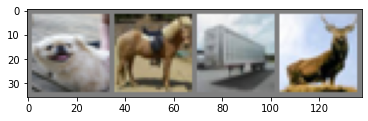

  dog horse truck  deer


In [177]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

4つだけ出力されるのは、上でバッチサイズを4にしているからである。

In [178]:
torchvision.utils.make_grid(images).size()

torch.Size([3, 36, 138])

https://pytorch.org/docs/stable/torchvision/utils.html
ここを見るとわかるが、
`torchvision.utils.make_grid(images)`
は、(B,C,H,W)の構造をもつデータからバッチ数分ある画像を結像して一つの(C,H,W)の構造を持つデータに変換することを行う。
この際様々なパラメータを与えることができて、例えば結合するときの画像間の間隔などを変えることができる。上の公式レファレンスか下のURL
https://blog.shikoan.com/torchvision-image-tile/
も参考になる。

ちなみに上の出力だと、`4*3*32*32`だったのを、`3*36*138`に変換している。これは、次のように理解できる。まず上下に、2ピクセルずつのマージンを加えているので、32から36になっており、横方向には、2ピクセルのマージンが5つ入っている。なので、`32 * 4 + 2 * 5 = 138`である。

また、同じところにある`torchvision.utils.save_image`を用いれば結合された画像を保存することができる。

また、imshow関数の中の以下の処理についても補足しておく。
`plt.imshow(np.transpose(npimg, (1, 2, 0)))`

NumpyのTranspose関数は多次元配列の軸の入れかえを行う関数である。この場合は、もともと`(0,1,2)`の構造を持っていたものを`(1,2,0)`に変えよということなので、`(C,H,W) -> (H,W,C)` の構造に変換したということである。

## ネットワークの定義

In [179]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Optimizerの定義

In [180]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## トレーニング 

In [154]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):#第2引数はインデックスの初期値
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)#ネットワークから出力された10個の値と、このループでのミニバッチのラベルを比較する。
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
#         if i%200 == 199:
#             print(loss,running_loss)
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.215
[1,  4000] loss: 1.850
[1,  6000] loss: 1.651
[1,  8000] loss: 1.567
[1, 10000] loss: 1.534
[1, 12000] loss: 1.471
[2,  2000] loss: 1.399
[2,  4000] loss: 1.389
[2,  6000] loss: 1.343
[2,  8000] loss: 1.319
[2, 10000] loss: 1.319
[2, 12000] loss: 1.299
Finished Training


pytorchでは、逆伝搬を行う前、すなわち`loss.backward()`を呼ぶ前に`optimizer.zero_grad()`で初期化しなければならない。
これはpytorchがデフォルトで`loss.backward()`は勾配を足し上げていくからである。これはRNN（回帰型ニューラルネットワーク https://en.wikipedia.org/wiki/Recurrent_neural_network ）では便利らしい。

optimizer.zero_grad()が必要な理由について書いてある記事
https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

`running_loss += loss.item()`この量はなんであるか理解する。
`loss.item()`が各ステップでのロスファンクションの値である。これを足し上げている量が`running_loss`。結局、出力の際`running_loss / 2000`を出力し、その後初期化しているのが読み取れる。

結局、これは2000ステップ（2000ミニバッチ）ごとのロスファンクションの平均値を与える。

## 学習結果の保存
学習後のウェイトの保存は以下で行う。

In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## テスト

以下に、まずデータセットの本当のラベルを表示する。

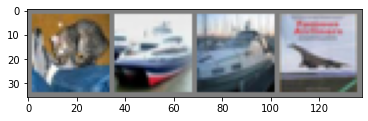

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

次に、学習済みのネットワークから判定を行う。

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
outputs = net(images)

In [18]:
print(outputs.size())
print(outputs)

torch.Size([4, 10])
tensor([[-1.0971e-01, -8.6737e-01,  6.0459e-02,  1.8125e+00, -1.3580e+00,
          1.4532e+00, -4.8291e-01, -9.6754e-01,  9.7564e-01, -7.9249e-01],
        [ 5.6473e+00,  3.5352e+00, -3.0057e-01, -2.5684e+00, -2.4953e+00,
         -4.9276e+00, -4.2188e+00, -2.8034e+00,  6.0902e+00,  2.5217e+00],
        [ 3.4311e+00,  2.5449e+00,  1.4699e-01, -1.4338e+00, -1.4442e+00,
         -3.0584e+00, -3.0181e+00, -1.7568e+00,  3.2958e+00,  1.8442e+00],
        [ 2.9602e+00,  1.9322e-01,  1.2653e+00, -1.4053e+00, -7.0096e-01,
         -1.8669e+00, -2.2233e+00, -8.6190e-01,  2.3235e+00, -4.2666e-03]],
       grad_fn=<AddmmBackward>)


In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


ここで行っているのは、`PATH`に保存した先ほどの学習結果（ウェイトの値）を`net.load_state_dict(torch.load(PATH))`でロードしている。つまりこのネットワークは、学習が正しく行われいる場合は分類器として動作するはずである。

`images`をnetに代入すると、ミニバッチの各4つの画像に対して、10次元の出力が得られる。このうち最も大きいものに分類されている可能性が高い。ということである。

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 65 %
Accuracy of  bird : 51 %
Accuracy of   cat : 27 %
Accuracy of  deer : 49 %
Accuracy of   dog : 39 %
Accuracy of  frog : 58 %
Accuracy of horse : 68 %
Accuracy of  ship : 69 %
Accuracy of truck : 56 %


ここで上のコードに関連していくつかチェックを行う。
上では、二つのテンソル型の量に対して、`(a == b).sum().item()`といった操作をしている。これの挙動を確認しておく。

In [22]:
a = torch.Tensor([1,2,3,4])
b = torch.Tensor([1,2,3,4])

In [23]:
print(a)
print(b)

print(a.size())
print(a.size(0))

(a == b)

tensor([1., 2., 3., 4.])
tensor([1., 2., 3., 4.])
torch.Size([4])
4


tensor([True, True, True, True])

このように、`a == b`の出力は`tensor([True, True, True, True])`であり、これに対して`sum()`メソッドを使うと、`tensor(4)`が返ってくる。これを`item()`で要素を取得しているので、結局テンソル`a,b`の各要素で同じものはいくつあるかを返している。

実際のケースでは、`predicted == labels`という形で使われており、これは学習済みのネットワークから出力された予言値が、実際のラベルと一致しているかを調べ、その正解数を返している。
`correct`にこの値を足していっているので、結局全体での正解数は`correct`に格納される。

In [24]:
(a == b).sum()

tensor(4)

In [25]:
(a == b).sum().item()

4

つまり、`total += labels.size(0)`でここまで判定した全ての画像の数を保存しており、`correct += (predicted == labels).sum().item()`で全正解数を保存している。ここから正解率を計算できるのである。

In [26]:
(a == b).squeeze()

tensor([True, True, True, True])

https://pytorch.org/docs/stable/generated/torch.squeeze.html

## Softmax スコアの評価

ソフトマックス関数を使えば、各データに対してそれがどのクラスに分類されるかの確率を得ることができる。

In [99]:
from scipy.special import softmax

net = Net()
net.load_state_dict(torch.load(PATH))

prediction = []
sm_list = []
label_list = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        label_list.append(labels.numpy())
        
        sm = softmax(outputs.numpy(),axis=1)#axis = 1 にしておくと確率を１に規格化する。
        sm_list.append(sm)
        
    sm_array = np.concatenate(sm_list)
    l_array = np.concatenate(label_list)

    #多いから最後のやつだけ表示
    print(sm.shape)
    print(sm)
    print(sm_array.shape)

(4, 10)
[[3.9243521e-03 1.2396303e-03 4.2648174e-02 3.7790892e-01 3.7232317e-02
  1.4802824e-01 3.7087616e-01 1.5703548e-02 1.0351248e-03 1.4034337e-03]
 [2.8444412e-03 6.0463313e-04 9.5011994e-02 1.5835993e-01 4.6296384e-02
  5.8381200e-01 7.3471270e-03 1.0402404e-01 9.3540212e-04 7.6417701e-04]
 [2.2861081e-01 3.3395942e-02 1.8843250e-01 1.3903287e-02 4.8888353e-01
  9.6217310e-03 3.7811762e-03 2.4095150e-02 6.2587322e-03 3.0171548e-03]
 [9.7758508e-05 1.4094601e-05 8.0374052e-04 1.8116916e-04 1.6973220e-02
  8.2338549e-04 7.0297741e-05 9.8102212e-01 3.0273156e-06 1.1564628e-05]]
(10000, 10)


上の出力を理解する。まず、`outputs`は`4*10`の次元を持っている。これは、ミニバッチに含まれる4つの画像に対してそれぞれ10個の出力があるからである。

さて、`softmax(array)`は、`array`に対してのソフトマックス関数を適用する。これは具体的には分配関数で規格化したとき、ある特定のエネルギーの配位が実現される確率に他ならない。

ソフトマックス関数の重要なパラメータは`axis`である。第一引数の`array`は一般に多次元配列でも許される。この際、どこで規格化するかを指定するのがこのパラメーターである。例えば、上では`axis = 1`にしているがこれは`axis = 1`に沿って和をとったとき、1になるように規格化するという意味である。

つまり今回のケースだと、第一引数には`outputs.numpy()`であるが、この型は`4 * 10`であった。`axis = 1`というのは`10`の方を意味する。つまりこの10個の量に対して足したら1になるように規格化を行うことになる。

もっと具体的にいうと、各画像データに対して、その画像が0～9のうちどれであるかの確率を出力することになる。

https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html    


このままだと、ソフトマックススコアがミニバッチに含まれる4つのデータごとに出力されている。しかし最終的な分析においてはミニバッチごとではなくデータ全体で分析したいので、これらを一つにまとめる。実際この場合では、`sm`は`4*10`の構造を持っていて、2500回ループする。この各ループで`sm`を`sm_list`に追加していくので、`sm_list`は`2500*4*10`の構造をもつ。

`np.concatenate(sm_list)`はこのリストの平滑化を行う。デフォルトでは`axis = 0`であるので、0軸にそって結合を行うことになる。詳しくはレファレンスを見るのがよい。
https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html

今回の場合は`2500*4*10->10000*10`のように構造を変える。

In [47]:
sm[0]

array([0.00392435, 0.00123963, 0.04264817, 0.37790892, 0.03723232,
       0.14802824, 0.37087616, 0.01570355, 0.00103512, 0.00140343],
      dtype=float32)

In [101]:
sm[3].sum()

1.0000004

In [50]:
print(sm_array[9999])

[9.7758508e-05 1.4094601e-05 8.0374052e-04 1.8116916e-04 1.6973220e-02
 8.2338549e-04 7.0297741e-05 9.8102212e-01 3.0273156e-06 1.1564628e-05]


### 可視化
基本的には、クラスの数で円を等分して、各動径方形に単位ベクトルを用意する。これをソフトマックススコアを係数として足したベクトルの位置に点を打っていくことで、ソフトマックススコアの分布をみることができる。

In [55]:
#クラスの数（ここでは10）
num_class = len(sm_array[0])
print(num_class)

10


In [65]:
#単位ベクトル
unit_x = np.array([ np.cos(2 * np.pi * i / num_class) for i in range(num_class)])
unit_y = np.array([ np.sin(2 * np.pi * i / num_class) for i in range(num_class)])

In [68]:
print(len(unit_x))
print(unit_x)

10
[ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.
 -0.80901699 -0.30901699  0.30901699  0.80901699]


In [78]:
list_x = []
list_y = []
for sm in sm_array:
    list_x.append(np.dot(unit_x , sm))
    list_y.append(np.dot(unit_y , sm))
    
print(len(list_x),list_x[0])

10000 -0.24760695904008265


#### 失敗
基本的な思想は問題ないが見栄えが悪くわかりずらい。

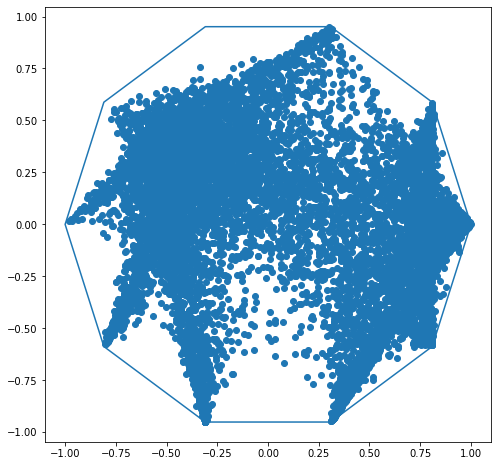

In [90]:
fig,axis=plt.subplots(figsize=(8,8),facecolor='w')
plt.plot(np.append(unit_x,unit_x[0]),np.append(unit_y,unit_y[0]))

plt.scatter(list_x,list_y)
plt.show()

#### 改良版
データごとに色分けされており、見やすくなった。

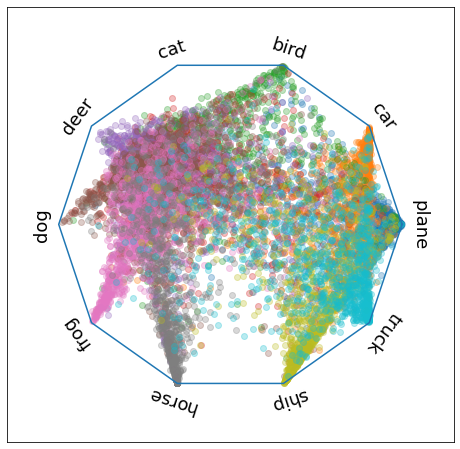

In [137]:
##############成型部分##################
#出力する図の大きさと背景の色の設定
fig,axis=plt.subplots(figsize=(8,8),facecolor='w')

#10角形の表示
plt.plot(np.append(unit_x,unit_x[0]),np.append(unit_y,unit_y[0]))

#グラフの軸を省略する
axis.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)

#マージンの設定
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
##########################################

#メインの出力
for label in range(num_class):
    idx = np.where(l_array == label)
    sm_class = sm_array[idx]
    
    list_x = []
    list_y = []
    
    for sm in sm_class:
        list_x.append(np.dot(unit_x , sm))
        list_y.append(np.dot(unit_y , sm))
    
    plt.scatter(list_x,list_y,alpha=0.3)
    
#クラス名の表示
#先頭のクラスが(0,0)の位置に来るので、ここで文字を-90度回転させる。そこから順番に360/10度ずつ足していけば円に沿って字が出力される。
for d,name in enumerate(classes):
        plt.text(unit_x[d]*1.1, unit_y[d]*1.1,str(name),fontsize=18,ha='center',va='center',rotation= -90 + 360/num_class*d)#-90 + 2 * np.pi/num_class*d/np.pi*180

plt.show()

ここでまた、いくつか補足をする。
```
for label in range(num_class):
```
このループは、0からクラスの数だけのループでその際のインデックスがlabelに入る。
よって、
```
idx = np.where(l_array == label)
```
は`l_array`、すなわちテスト用データのラベルが格納されたリストから、このループ内での`label`に等しいものを抽出し、リストとして入る。

つまり、例えば`label`が0の時、`idx`にテストデータのうちplaneの画像データのインデックスが格納される。

numpy arrayでは下のように、リストで呼び出すことができる。つまり`a[[1,3,5]]`は`a`から`1，3，5`番目の要素を返す。

よって`idx`を用いて各ラベルのデータを一括で呼び出すことができるのである。

In [117]:
print(len(idx[0]))
print(len(sm_array[idx]))

a = np.array( [0,2,4,6,8,10])
a[[1,3,5]]

1000
1000


array([ 2,  6, 10])

# GPU を用いた計算

In [181]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [182]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [184]:
index = 0
epoch_num = 10

for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):#第2引数はインデックスの初期値
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)#ネットワークから出力された10個の値と、このループでのミニバッチのラベルを比較する。
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
#         if i%200 == 199:
#             print(loss,running_loss)
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            PATH = './weights/cifar_net-'+ str(index)+'.pth'
            torch.save(net.state_dict(), PATH)
            index += 1

print('Finished Training')

[1,  2000] loss: 1.329
[1,  4000] loss: 1.300
[1,  6000] loss: 1.273
[1,  8000] loss: 1.269
[1, 10000] loss: 1.251
[1, 12000] loss: 1.234
[2,  2000] loss: 1.182
[2,  4000] loss: 1.179
[2,  6000] loss: 1.170
[2,  8000] loss: 1.153
[2, 10000] loss: 1.139
[2, 12000] loss: 1.136
[3,  2000] loss: 1.070
[3,  4000] loss: 1.078
[3,  6000] loss: 1.084
[3,  8000] loss: 1.077
[3, 10000] loss: 1.096
[3, 12000] loss: 1.065
[4,  2000] loss: 1.010
[4,  4000] loss: 0.993
[4,  6000] loss: 1.013
[4,  8000] loss: 1.013
[4, 10000] loss: 1.018
[4, 12000] loss: 1.016
[5,  2000] loss: 0.955
[5,  4000] loss: 0.949
[5,  6000] loss: 0.953
[5,  8000] loss: 0.969
[5, 10000] loss: 0.968
[5, 12000] loss: 0.954
[6,  2000] loss: 0.888
[6,  4000] loss: 0.895
[6,  6000] loss: 0.887
[6,  8000] loss: 0.919
[6, 10000] loss: 0.951
[6, 12000] loss: 0.922
[7,  2000] loss: 0.855
[7,  4000] loss: 0.853
[7,  6000] loss: 0.879
[7,  8000] loss: 0.901
[7, 10000] loss: 0.868
[7, 12000] loss: 0.881
[8,  2000] loss: 0.796
[8,  4000] 

## 過学習の判定
過学習は、学習誤差は小さいのにも関わらず、汎化誤差が大きくなる現象である。つまりロスファンクションが小さくなっているにも関わらず、繁華誤差が大きくると過学習が起きた判定になる。

そこで、学習のループでいくつかのステップごとにウェイトを保存することにする（上のコードはそれを実行している）。

今回は出力のタイミング、つまり2000ステップごとにウェイトを保存したので全部で60個のウェイトデータが得られたことになる。

In [197]:
file_num = int(10 * np.floor(50000/4/2000))
print(file_num)

60


それぞれのウェイトをネットワークに読み込ませて、正答率を計算させる。
その結果をリストに保存していき最後に図として出力した。

In [208]:
list_ratio = np.array([])

for index in range(file_num):
    PATH = PATH = './weights/cifar_net-'+ str(index)+'.pth'
    net = Net()
    net.load_state_dict(torch.load(PATH))

    outputs = net(images)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    list_ratio = np.append(list_ratio, correct/total)
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 53 %
Accuracy of the network on the 10000 test images: 54 %
Accuracy of the network on the 10000 test images: 54 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 58 %
Accuracy of the network on the 10000 test images: 58 %
Accuracy of the network on the 10000 test images: 58 %
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 61 %
Accuracy o

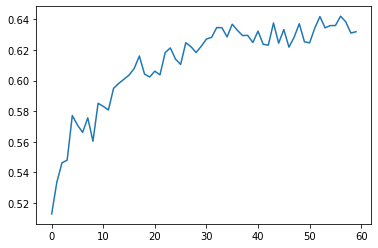

In [209]:
plt.plot(list_ratio)
plt.show()

このように図から、正答率は単調に増加しており、汎化誤差は大きくなっていない。つまりこの範囲においては過学習はないといえるでろう。

## 考察と課題
ここで再びSoftMaxを評価する。

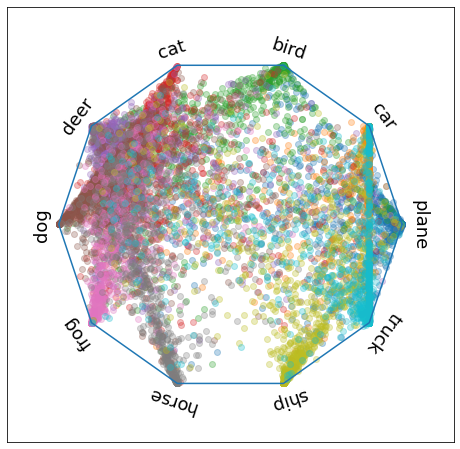

In [210]:
from scipy.special import softmax

net = Net()
net.load_state_dict(torch.load(PATH))

prediction = []
sm_list = []
label_list = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        label_list.append(labels.numpy())
        
        sm = softmax(outputs.numpy(),axis=1)#axis = 1 にしておくと確率を１に規格化する。
        sm_list.append(sm)
        
    sm_array = np.concatenate(sm_list)
    l_array = np.concatenate(label_list)

list_x = []
list_y = []
for sm in sm_array:
    list_x.append(np.dot(unit_x , sm))
    list_y.append(np.dot(unit_y , sm))
        
fig,axis=plt.subplots(figsize=(8,8),facecolor='w')
plt.plot(np.append(unit_x,unit_x[0]),np.append(unit_y,unit_y[0]))
axis.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)

for label in range(num_class):
    idx = np.where(l_array == label)
    sm_class = sm_array[idx]
    
    list_x = []
    list_y = []
    
    for sm in sm_class:
        list_x.append(np.dot(unit_x , sm))
        list_y.append(np.dot(unit_y , sm))
    
    plt.scatter(list_x,list_y,alpha=0.3)
    
for d,name in enumerate(classes):
        plt.text(unit_x[d]*1.1, unit_y[d]*1.1,str(name),fontsize=18,ha='center',va='center',rotation= -90 + 360/num_class*d)#-90 + 2 * np.pi/num_class*d/np.pi*180

plt.show()

この図を見たら分かるように、、例えば車とトラックを結ぶ直線が見て取れる。これは車とトラックの間で良く間違いが起こっていることを示している。
gamma と electronの識別問題は本質的に車とトラックを分類する問題と同じである。

これらをさらに正確に分類するにはどうすればよいのであろうか。

まず試してみたいのは、車とトラックだけの教師データを用意して学習させたらどうなるだろうか？

他にも例えばGANは？GANだったら車のデータ（5000枚ある）からFake車を生成し、車かどうかを判定する。この学習でできた判定機にトラックを判定させたらどうなるのだろうか？
